In [1]:
import bayes3d as b
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
import jax.tree_util as jtu
from tqdm import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7013/static/


In [3]:
b.RENDERER = None
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=100.0, fy=100.0,
    cx=50.0, cy=50.0,
    near=0.01, far=50.0
)

b.setup_renderer(intrinsics)

b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(),"sample_objs/table.obj"))
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(),"sample_objs/box_large.obj"))
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(),"sample_objs/orange.obj"))

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [4]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 2.6, 2.3]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 1.0, 0.0]),
    )
)
all_box_dims = b.RENDERER.model_box_dims
key = jax.random.PRNGKey(13)
OUTLIER_VOLUME = 1000.0

In [7]:
def get_poses(ids, *args):
    full_ids = jnp.concatenate([jnp.array([0]), ids])
    root_poses = jnp.tile(table_pose[None,...], (ids.shape[0] + 1, 1,1))
    return full_ids, b.scene_graph.poses_from_scene_graph(
        root_poses,
        b.RENDERER.model_box_dims[full_ids],
        jnp.concatenate([jnp.array([-1]), jnp.full(ids.shape, 0)]),
        jnp.stack([jnp.zeros((3,)), *args]),
        jnp.full(full_ids.shape, 0),
        jnp.full(full_ids.shape, 1),
    )
get_poses_jit = jax.jit(get_poses)
get_poses_parallel = jax.jit(jax.vmap(
    get_poses,
    in_axes=(None, None, None, 0)
))

def render_depth(ids, *contact_params):
    full_ids, poses = get_poses(ids, *contact_params)
    return b.RENDERER.render(poses, full_ids)[:,:,:3]
render_depth_jit = jax.jit(render_depth)

def score_scene(observed_image, ids, variance, outlier_prob, *contact_params):
    rendered = render_depth(ids, *contact_params)
    return b.threedp3_likelihood(observed_image, rendered, variance, outlier_prob, OUTLIER_VOLUME, 1)
score_scene_jit = jax.jit(score_scene)

def viz_trace(ids, *contact_params):
    all_ids, poses = get_poses_jit(ids, *contact_params)
    colors = b.viz.distinct_colors(max(10, len(all_ids)))
    b.clear()
    for (i,(id,p)) in enumerate(zip(all_ids, poses)):
        b.show_trimesh(f"obj_{i}", b.RENDERER.meshes[id],color=colors[i])
        b.set_pose(f"obj_{i}", p)

    depth = render_depth_jit(ids, *contact_params)
    b.show_cloud("depth", depth[:,:,:3].reshape(-1,3))

parallel_scorer = jax.jit(jax.vmap(
    score_scene,
    in_axes=(None, None, None, None, None, None, 0)
))

contact_bounds = jnp.array([jnp.array([-2.5, -2.5, -2*jnp.pi]), jnp.array([2.5, 2.5, 2*jnp.pi])]),

19768.008


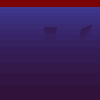

In [36]:
N = 2
gt_ids = jnp.array([1, 1])
key = jax.random.PRNGKey(10)
gt_contact_params = (jnp.array([0.0, 0.0, jnp.pi/2]), jnp.array([1.0, 0.0, jnp.pi/3]))
observed_image = render_depth(gt_ids, *gt_contact_params)
viz_trace(gt_ids, *gt_contact_params)
score = score_scene(observed_image, gt_ids, 0.0001, 0.0001, *gt_contact_params)
print(score)
b.get_depth_image(observed_image[:,:,2])

In [18]:
bounds = 1.5
grid = b.utils.make_translation_grid_enumeration_3d(
    -bounds, -bounds, -0.0,
    bounds, bounds, 0.0,
    50,50,1
)

In [29]:
ids = jnp.array([1, 1, 2])
scores = parallel_scorer(observed_image, ids, 0.0001, 0.0001, *contact_params, grid)
print(scores.min(), scores.max())

19454.14 19768.008


In [32]:
sampled_indices = jax.random.categorical(key, scores, shape=(100,))
sampled_poses = get_poses_parallel(ids, *contact_params, grid[sampled_indices])[1][:,-1,...]

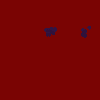

In [33]:
img = b.RENDERER.render(sampled_poses, jnp.full(sampled_poses.shape[0], 2))
b.get_depth_image(img[:,:,2])

In [37]:
viz_trace(gt_ids, *gt_contact_params)
final_id = ids[-1]
for (i,p) in enumerate(sampled_poses):
    b.show_trimesh(f"target_obj_{i}", b.RENDERER.meshes[final_id])
    b.set_pose(f"target_obj_{i}", p)